# Creating a Time-Averaged Visibility Model
Katherine Elder, ASU
<p>August 13, 2018

While looking at delay spectra of the IDR2.1 cross-polarized HERA visibilities, the HERA team noticed certain constant patterns within the peaks. One of these patterns was that each spectra had a peak at the delay corresponding to the baseline in nanoseconds. As we dug into these patterns, we came up with the hypothesis that the delay spectrum could be modeled with only a few variables: namely, the baseline, autocorrelations, the delay of the signal traveling through cables, and a couple of amplitude variables. 

The purpose of this notebook is to create and plot a physically motivated model of the time averaged offset observed in IDR2.1 cross-polarized HERA visibilities. Our model equation looks like:

$V_{ij} = P_{ij} \cdot e^{-i 2\pi \tau_{aij} \nu} \cdot (V_{ii} + V_{jj})$
        $+ \varepsilon_{ij} \cdot (V_{ii} \cdot e^{i 2\pi \tau_{ci} \nu} + V_{jj} \cdot e^{i 2\pi \tau_{cj} \nu})$

$V_{ij}$ : the data averaged across time

$P_{ij}$ : the amplitude of the signal traveling along baselines over the air

$\tau_{aij}$ : the delay of the signal traveling along baselines over the air

$\nu$ : the frequency

$V_{ii}$, $V_{jj}$ : the autocorrelation for each of the two antennas

$\varepsilon_{ij}$ : the amplitude of the signal traveling distances unrealted to the baseline

$\tau_{ci}$, $\tau_{cj}$ : the delay of the signal traveling distances unrelated to the baseline

The first task is to import necessary packages, define constants, and read in the data. 

In [45]:
#Initialize matplotlib notebook
%matplotlib notebook
#Import needed packages
from pyuvdata import UVData
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import amp_delay_plotting as adp

#Create uv elements
uv = UVData()

#Variable for the speed of light
c = 2.99792e8

#Create an array of antennas we want to flag
#Antennas 26 and 84 are not dead, but have been flagged in the files and so cause problems
flagged_antennas = np.array([0,2,26,50,84,98,136])

#Read in the data file
#This is the combined, time averaged data file created with read_all_uvfit.py
uv.read_uvfits('/data6/HERA/data/IDR2.1/uvOCRSL_crosspol_time_split/xy_time_split_data/combined_files/zen.grp1.of1.xy.LST.run_7.uvOCRSL.uvfits')

#Define frequency variable. This makes life easier and code cleaner when using this array
#Nu is in Hz, or 1/seconds
nu = uv.freq_array

#Create a dictionary which associates the antenna number with the indexing number in uv.antenna_numbers
#This is used to find antennas in the matrix arrays
ant_dict = {x: i for i,x in enumerate(uv.antenna_numbers)}

Next, we create matricies and arrays that will be used in our functions to build the model. 

taus_a : this matrix holds the calculated baseline length for every antenna pair. It is used for the baseline dependent delay.

V_k : this array holds the autocorrelation data for every antenna. It is used for the autocorrelation terms. 

bl_amp : this matrix holds the amplitudes of the baseline dependent peak for every antenna pair. This is used for the baseline dependent amplitude term. 

out_bl_amp : this matrix hold the amplitudes of the maximum peaks on either side of baseline dependence. This is used for the non-baseline dependent amplitude term. 

out_bl_delay : this matrix holds the corresponding delays for the amplitudes saved in the matrix above. This is used for the non-baseline dependent delay term. 

P_ij : the baseline dependent amplitude term

Eps_ija, Eps_ijb : the non-baseline dependent amplitude terms

In [46]:
#General arrays and matricies used in model

#Create the baseline tau matrix
taus_a = np.zeros((len(uv.antenna_numbers),len(uv.antenna_numbers)))
i = 0
j = 0
for ind,coord in enumerate(uv.uvw_array):
    #This if statement iterates the indicies for the created tau array
    if j==52:
        #When j hits 52, it has reached the end of the list of antennas
        #This means that we need to move to the next line and so i is iterated
        #But we cannot simply reset j to zero because the uvw array does not repeat baselines
        #We set j equal to i, as the new row will start will the autocorr baseline
        i = i + 1
        j = i
    #Calculate the absolute distance in meters separating the antenna pair
    taus_a[i,j] = np.sqrt(coord[0]**2 + coord[1]**2 + coord[2]**2) 
    #Convert tau from meters into seconds
    taus_a[i,j] = taus_a[i,j] / c
    #Iterate the j index
    j = j + 1
    
#Create an array to hold the autocorrelation data
V_k = np.zeros((len(uv.antenna_numbers),uv.Nfreqs),dtype='complex')
# Step through each antenna and find autocorr data
for i,ant1 in enumerate(uv.ant_2_array):
    ant2 = uv.ant_1_array[i]
    if (ant1==ant2):
        V_k[ant_dict[ant1]] = uv.data_array[i,0,:,0]
        
#The first dimension is there so that we can multiply the matricies later
#Dimentions 2 and 3 hold the matrix of antenna pairs
bl_amp = np.zeros([1,len(uv.antenna_numbers),len(uv.antenna_numbers)])
#The first dimension is there so that we can multiply the matricies later
#The second dimension holds the amplitude below baseline in element 0, and element 1 holds amplitude above baseline
#Dimentions 3 and 4 hold the matrix of antenna pairs
out_bl_amp = np.zeros([1,2,len(uv.antenna_numbers),len(uv.antenna_numbers)])
#This array holds the matrix of delays for each antenna pairs
#The first dimension holds the amplitude below baseline in element 0, and element 1 holds amplitude above baseline
out_bl_delay = np.zeros([2,len(uv.antenna_numbers),len(uv.antenna_numbers)])
#Step through the antenna array to find every baseline
for index,ant1 in enumerate(uv.ant_1_array):
    #Get the second antenna number using the index number
    ant2 = uv.ant_2_array[index]

    #Skip our flagged antennas
    if np.any(ant1==flagged_antennas) or np.any(ant2==flagged_antennas):
        continue
    
    #Find the baseline delay amplitude and location
    baseline = 0
    if ant1<ant2:
        tau_b = taus_a[ant_dict[ant1],ant_dict[ant2]]
    else:
        tau_b = taus_a[ant_dict[ant2],ant_dict[ant1]]
    #Calculate the exponential with the baseline tau delay
    expo = np.e**(nu * np.pi * (-1j) * 2 * tau_b)
    #Take the delay transform
    vis_expo = np.mean(np.fft.fftshift(np.fft.fft(expo,axis=1)),axis=0)
    #Find the maximum value
    expo_max = np.max(np.abs(vis_expo))
    #Find the location of the maximum, which is the baseline
    expo_peak = int(np.argwhere(np.abs(vis_expo)==expo_max))
    
    # Create an array to hold the real data
    spectrum = uv.data_array[index,0,:,0]
    # Fourier transform along the time axis
    vis = np.fft.fftshift(np.fft.fft(spectrum))
    freq_width = np.diff(uv.freq_array[0,:])[0]
    #Convert frequencies to delays and convert to ns
    con_delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs, freq_width))*1e9
    
    # Find the maximum amplitudes and put into corresponding variables
    #Find the peak at the baseline
    bl_peak = np.max(np.abs(vis)[expo_peak-2:expo_peak+3])
    #This finds the amplitude below, or less than, the baseline
    peak_below_bl = np.max(np.abs(vis)[:expo_peak-10])
    #This finds the amplitude above, or greater than, the baseline
    peak_above_bl = np.max(np.abs(vis)[expo_peak+10:])
    
    #Find the corresponding delays
    delay_below = con_delays[np.argwhere(np.abs(vis)==peak_below_bl)]
    delay_above = con_delays[np.argwhere(np.abs(vis)==peak_above_bl)]
    
    #Append the outside baseline delay array with the delay in seconds
    out_bl_delay[1,ant_dict[ant1],ant_dict[ant2]] = delay_above / 1e9
    out_bl_delay[1,ant_dict[ant2],ant_dict[ant1]] = delay_above / 1e9
    out_bl_delay[0,ant_dict[ant1],ant_dict[ant2]] = delay_below / 1e9
    out_bl_delay[0,ant_dict[ant2],ant_dict[ant1]] = delay_below / 1e9
    
    # Append the outside baseline amplitude array with the peak
    out_bl_amp[0,1,ant_dict[ant1],ant_dict[ant2]] = peak_above_bl
    out_bl_amp[0,1,ant_dict[ant2],ant_dict[ant1]] = peak_above_bl
    out_bl_amp[0,0,ant_dict[ant1],ant_dict[ant2]] = peak_below_bl
    out_bl_amp[0,0,ant_dict[ant2],ant_dict[ant1]] = peak_below_bl
    
    # Append the baseline amplitude array with the peak
    bl_amp[0,ant_dict[ant1],ant_dict[ant2]] = bl_peak
    bl_amp[0,ant_dict[ant2],ant_dict[ant1]] = bl_peak
    
print 'Baseline amplitude array:', bl_amp.shape
print 'Outside baseline delay array:', out_bl_delay.shape
print 'Outside baseline amplitude array:', out_bl_amp.shape

#Take the average across antennas to calculate the baseline amplitude factor
P_ij = np.mean(bl_amp,axis=1)
#Take the average across antennas to calculate the outside baseline amplitude factors
Eps_ijb = np.mean(out_bl_amp[:,0],axis=1)
Eps_ija = np.mean(out_bl_amp[:,1],axis=1)

Baseline amplitude array: (1, 52, 52)
Outside baseline delay array: (2, 52, 52)
Outside baseline amplitude array: (1, 2, 52, 52)


Now we define functions to build and plot the model against the real data. 

<b>build_vis_model</b> : calculate the model for the entered antenna pair
    
    input   : ant1, ant2
    returns : bl_model, out_bl_modela, out_bl_modelb

In [47]:
def build_vis_model(ant1,ant2):
    '''
    This function calculates and builds the model for the entered antenna numbers

    Parameters
    ----------
    ant1 : int
        The first antenna of the pair
    ant2 : int
        The second antenna number of the pair

    Returns
    -------
    bl_model : ndarray 
        This array, sized (52, 1024), holds the model for the baseline dependent piece of the model
    out_bl_modela : ndarray
        This array, sized (52, 1024), holds the model for the above baseline dependent piece of the model
    out_bl_modelb : ndarray
        This array, sized (52, 1024), holds the model for the below baseline dependent piece of the model

    '''

    #Define the tau variable for the specified antenna pair
    #Since the array created is upper triangular, we must index using an if statement
    if ant1<ant2:
        tau_aij = taus_a[ant_dict[ant1],ant_dict[ant2]]
    else:
        tau_aij = taus_a[ant_dict[ant2],ant_dict[ant1]]    
    #Print the baseline in meters and in nanoseconds
    print 'Tau_aij (m) :',tau_aij*c
    print 'Tau_aij (ns):',tau_aij*1e9
    
    #Define the tau_c variables for the specified antenna pair
    #i corresponds to the first antenna, j corresponds to the second antenna
    #b corresponds to below baseline, a corresponds to above baseline
    tau_cib = out_bl_delay[0,ant_dict[ant1],ant_dict[ant2]]
    tau_cjb = out_bl_delay[0,ant_dict[ant2],ant_dict[ant1]]
    tau_cia = out_bl_delay[1,ant_dict[ant1],ant_dict[ant2]]
    tau_cja = out_bl_delay[1,ant_dict[ant2],ant_dict[ant1]]
    #Print the delays in nanoseconds
    print 'Tau_cib (ns):', tau_cib*1e9
    print 'Tau_cjb (ns):', tau_cjb*1e9
    print 'Tau_cia (ns):', tau_cia*1e9
    print 'Tau_cja (ns):', tau_cja*1e9

    #Define the exponential terms for ci 
    #The factor of 20 is used to reduce the amplitude of the model and minimize the correction factor when plotting
    e_cia = np.e**((1j) * 2 * np.pi * nu * tau_cia) / 20
    e_cib = np.e**((1j) * 2 * np.pi * nu * tau_cib) / 20
    #Define the exponential term for cj
    e_cja = np.e**((1j) * 2 * np.pi * nu * tau_cja) / 20
    e_cjb = np.e**((1j) * 2 * np.pi * nu * tau_cjb) / 20
    #Define the exponential term for baseline
    #We must add a correction factor of 10 ns to the baseline
    e_aij = np.e**((-1j) * 2 * np.pi * nu * (tau_aij + 1e-8)) / 20

    #Define autocorrelation variables
    V_ii = V_k[ant_dict[ant1]]
    V_jj = V_k[ant_dict[ant2]]

    #Define baseline dependent term of the model, with another amplitude correction factor
    V_aij = (e_aij * (V_ii + V_jj)) / 20
    
    #Define the non-baseline dependent terms of the model
    V_cija = ((V_ii * e_cia) + (V_jj * e_cja)) / 20
    V_cijb = ((V_ii * e_cib) + (V_jj * e_cjb)) / 20
    
    #Finish building the terms of the model
    out_bl_modela = np.einsum('im,ij->mj',Eps_ija,V_cija)
    out_bl_modelb = np.einsum('im,ij->mj',Eps_ijb,V_cijb)
    bl_model = np.einsum('im,ij->mj',P_ij,V_aij)
    
    #Return our model arrays
    return(bl_model,out_bl_modela,out_bl_modelb)

<b>real_vis_spec</b> : calculate the visibility spectrum from the real data for the entered antenna pair
    
    input   : antenna1, antenna2, uv
    returns : vis

In [48]:
def real_vis_spec(antenna1,antenna2,uv):
    '''
    This function calculates the visibility spectrum of the real data for the entered antenna pair

    Parameters
    ----------
    anteena1 : int
        The first antenna of the pair
    antenna2 : int
        The second antenna number of the pair
    uv : uv data object
        The uv object which read in the data file we are using

    Returns
    -------
    vis : ndarray 
        This array, sized (1024,), holds the spectrum of the real data

    '''
    
    #Delay transform of the real data
    #First, we read in the data from the data array
    spectra = []
    for index,ant1 in enumerate(uv.ant_2_array):
        #Get the second antenna number using the index number
        ant2 = uv.ant_1_array[index]
        #Locate the antenna pair we want
        if (ant1==antenna1 and ant2==antenna2) or (ant1==antenna2 and ant2==antenna1):
            #Place the data into the array created outside of the loop
            spectra = uv.data_array[index,0,:,0]

    #Take the fourier transform of the data
    vis = np.fft.fftshift(np.fft.fft(spectra))
    
    #Return the data
    return(vis)

<b>plot_model</b> : plot the model and the real data
    
    input : vis_bl_model, out_bl_modela, out_bl_modelb, uv

In [82]:
def plot_model(vis_bl_model,out_bl_modela,out_bl_modelb,uv):
    '''
    This function calculates the visibility spectrum of the model and plots with the real data spectrum

    Parameters
    ----------
    vis_bl_model : ndarray
        This array, sized (52, 1024), holds the model for the baseline dependent piece of the model
    out_bl_modela : ndarray
        This array, sized (52, 1024), holds the model for the above baseline dependent piece of the model
    out_bl_modelb : ndarray
        This array, sized (52, 1024), holds the model for the below baseline dependent piece of the model
    uv : uv data object
        The uv object which read in the data file we are using

    '''
    #Take the delay transform of the models
    vis_bl_model = np.mean(np.fft.fftshift(np.fft.fft(vis_bl_model,axis=1)),axis=0)
    vis_out_bl_modela = np.mean(np.fft.fftshift(np.fft.fft(out_bl_modela,axis=1)),axis=0)
    vis_out_bl_modelb = np.mean(np.fft.fftshift(np.fft.fft(out_bl_modelb,axis=1)),axis=0)

    #Find the maximum value of each transform
    model_max_bl = np.max(np.abs(vis_bl_model))
    model_max_a = np.max(np.abs(vis_out_bl_modela))
    model_max_b = np.max(np.abs(vis_out_bl_modelb))
    
    #Find the location in the array for each maxima
    model_a_peak = int(np.argwhere(np.abs(vis_out_bl_modela)==model_max_a))
    model_bl_peak = int(np.argwhere(np.abs(vis_bl_model)==model_max_bl))
    model_b_peak = int(np.argwhere(np.abs(vis_out_bl_modelb)==model_max_b))
    
    #Find the frequency width of a channel in GHz
    freq_width = np.diff(uv.freq_array[0,:])[0]
    #Convert frequencies to delays and convert to ns
    delays = np.fft.fftshift(np.fft.fftfreq(uv.Nfreqs,freq_width)*1e9)
    
    #Call the real_vis_spec function to get the real data
    vis_real = real_vis_spec(antenna1,antenna2,uv)
    
    #Find the maximum peak in the real data corresponding to the peaks in the model
    real_below_max = np.max(np.abs(vis_real[(model_b_peak-5):(model_b_peak+5)]))
    real_above_max = np.max(np.abs(vis_real[(model_a_peak-5):(model_a_peak+5)]))
    real_bl_max = np.max(np.abs(vis_real[(model_bl_peak-5):(model_bl_peak+5)]))
    
    #Calculate the correction factors
    bl_factor = model_max_bl / real_bl_max
    below_factor = model_max_b / real_below_max
    above_factor = model_max_a / real_above_max
    
    #Finish putting the model together, with correction factors
    model = (vis_bl_model/bl_factor) + (vis_out_bl_modelb/below_factor) + (vis_out_bl_modela/above_factor)
    
    #Plot the spectra
    #Open the figures so that if one is zoomed in, the other zooms as well
    fig = plt.figure(figsize=(9,5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2, sharey = ax1, sharex = ax1)

    plt.subplot(ax1)
    plt.plot((delays),np.abs(vis_real), label='Real')
    plt.plot((delays),np.abs(model), label='Model')
    plt.xlabel('Delay (ns)')
    plt.xlim(-2000,2000) # zoom-in
    plt.legend()
    plt.title('XY Delay Transform, real and model')

    plt.subplot(ax2)
    plt.plot(delays, np.abs(np.abs(vis_real)-np.abs(model)))
    plt.xlabel('Delay (ns)')
    plt.title('Difference between data and model')
    
    print 'Real variance :', np.var(vis_real)
    print 'Model variance:', np.var(model)
    print 'Difference variance:', np.var((vis_real-model))

We now prompt the user to enter the desired antenna pair. We run a check on the entered numbers to be sure they are valid antenna numbers. 

In [88]:
#Prompt the user to enter the first antenna number of the pair
antenna1 = input('Please enter the first antenna number: ')
antenna1 = int(antenna1)
#Check that the antenna number is valid
antenna1 = adp.check_antnum(antnum=antenna1, ants=uv.antenna_numbers)
#Prompt the user to enter the second antenna number of the pair
antenna2 = input('Please enter the second antenna number: ')
antenna2 = int(antenna2)
#Check that the antenna number is valid
antenna2 = adp.check_antnum(antnum=antenna2, ants=uv.antenna_numbers)

Please enter the first antenna number: 137
Please enter the second antenna number: 124


Now we can call the functions we defined above and plot our model

Tau_aij (m) : 95.79168049257534
Tau_aij (ns): 319.5271404593029
Tau_cib (ns): -910.0
Tau_cjb (ns): -910.0
Tau_cia (ns): 1180.0
Tau_cja (ns): 1180.0


<IPython.core.display.Javascript object>


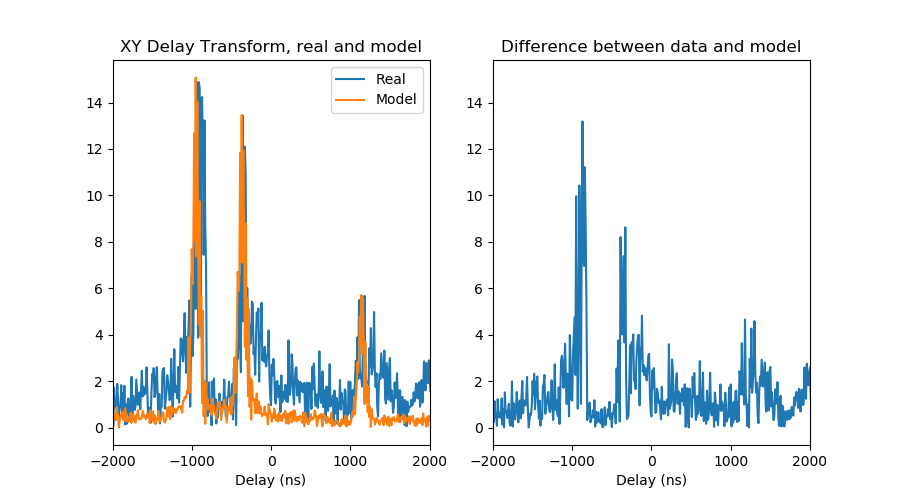

Real variance : 5.1856775
Model variance: 2.4278535587339833
Difference variance: 8.517199019472915


In [89]:
#Call functions and plot

#Build the visibility model
bl_model, out_model_a, out_model_b = build_vis_model(ant1=antenna1,ant2=antenna2)

#Plot the model with the real data
plot_model(bl_model,out_model_a,out_model_b,uv)